# ０～９までの数字の画像からどの数字なのかを推論する畳み込みニューラルネットワーク（CNN）モデルの構築

#### データセットの準備

In [1]:
from datasets import load_dataset
ds = load_dataset("ylecun/mnist")

f:\deep-learning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#### データセットの確認

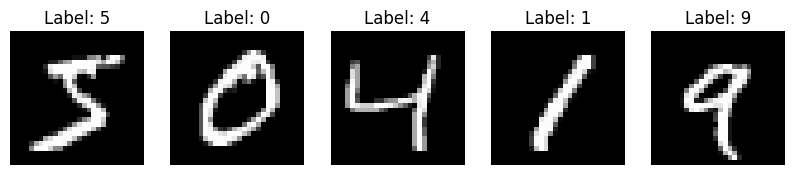

In [3]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    image = ds['train'][i]['image']
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Label: {ds['train'][i]['label']}")
    ax.axis('off')
plt.show()

In [4]:
ds['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 5}

In [6]:
print(f"画像サイズ {image.size}")

画像サイズ (28, 28)


In [17]:
# 型の変換
ds.set_format(type='torch', columns=['image', 'label'])

#### 畳み込みニューラルネットワークのモデルを定義

In [70]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # x = x.view(-1, 64)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


##### モデルの動作確認

In [71]:
# 1つ目のデータを取得
train_loader = torch.utils.data.DataLoader(ds['train'])
data_iter = iter(train_loader)
batch = next(data_iter)
images, labels = batch['image'], batch['label']
print(images.size())
print(labels)

torch.Size([1, 1, 28, 28])
tensor([5])


In [72]:
# 1つ目のデータをモデルに入力
pred = model(images.squeeze(2).float())
print(f"output shape: {pred.shape}")
print(pred.min(), pred.max())
print(pred)

output shape: torch.Size([1, 10])
tensor(0.0018, grad_fn=<MinBackward1>) tensor(0.6682, grad_fn=<MaxBackward1>)
tensor([[0.0360, 0.0799, 0.6682, 0.0713, 0.0018, 0.0273, 0.0175, 0.0530, 0.0098,
         0.0351]], grad_fn=<SoftmaxBackward0>)


#### 損失関数とオプティマイザーを設定

In [79]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### モデルを訓練

In [ ]:
# データローダーの作成
train_loader = torch.utils.data.DataLoader(ds['train'], batch_size=64, shuffle=True)

# モデルの訓練
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data['image'], data['label']
        inputs = inputs.squeeze(2).float()

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:    # 100ミニバッチごとに平均損失を出力
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print('Finished Training')

[1, 100] loss: 1.978
[1, 200] loss: 1.788
[1, 300] loss: 1.712
[1, 400] loss: 1.604
[1, 500] loss: 1.599
[1, 600] loss: 1.579
[1, 700] loss: 1.513
[1, 800] loss: 1.504
[1, 900] loss: 1.507
[2, 100] loss: 1.503
[2, 200] loss: 1.498
[2, 300] loss: 1.501
[2, 400] loss: 1.496
[2, 500] loss: 1.496
[2, 600] loss: 1.500
[2, 700] loss: 1.498
[2, 800] loss: 1.497
[2, 900] loss: 1.506
[3, 100] loss: 1.495
[3, 200] loss: 1.492
[3, 300] loss: 1.490
[3, 400] loss: 1.491
[3, 500] loss: 1.497
[3, 600] loss: 1.489
[3, 700] loss: 1.494
[3, 800] loss: 1.488
[3, 900] loss: 1.497
[4, 100] loss: 1.493
[4, 200] loss: 1.492
[4, 300] loss: 1.493
[4, 400] loss: 1.490
[4, 500] loss: 1.496
[4, 600] loss: 1.486
[4, 700] loss: 1.491
[4, 800] loss: 1.495
[4, 900] loss: 1.487
[5, 100] loss: 1.490
[5, 200] loss: 1.489
[5, 300] loss: 1.495
[5, 400] loss: 1.494
[5, 500] loss: 1.499
[5, 600] loss: 1.495
[5, 700] loss: 1.491
[5, 800] loss: 1.496
[5, 900] loss: 1.492
[6, 100] loss: 1.489
[6, 200] loss: 1.488
[6, 300] loss

#### 評価

In [75]:
model.eval()

test_loader = torch.utils.data.DataLoader(ds['train'], batch_size=4, shuffle=False)

preds_list = []
actuals_list = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data['image'], data['label']
        images = images.squeeze(2).float()
        outpts = model(images)
        _, preds = torch.max(outputs, 1)
        preds_list.extend(preds)
        actuals_list.extend(labels)

##### ヒートマップでビジュアライズ

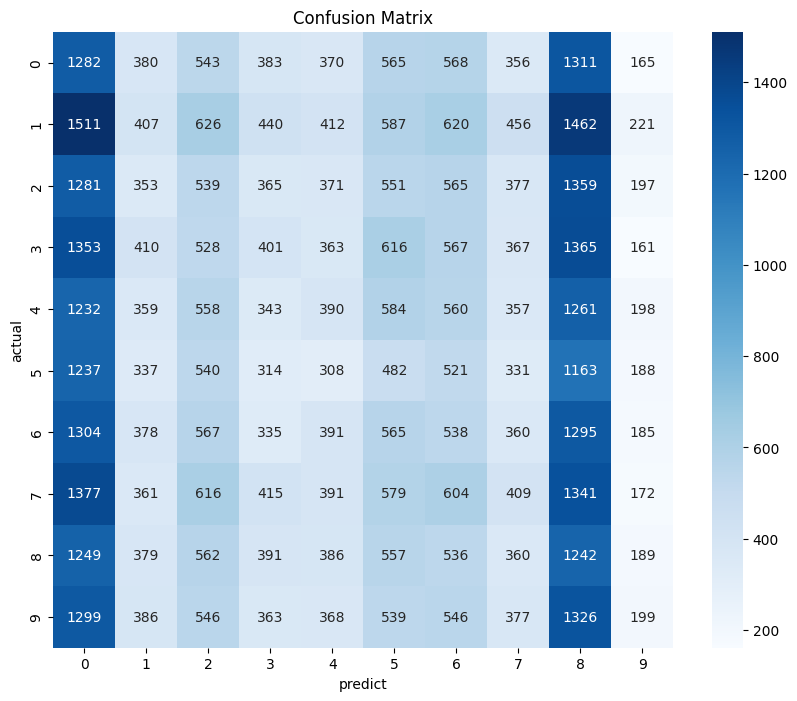

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ensure both lists have the same length
preds_list = preds_list[:len(actuals_list)]

cm = confusion_matrix(actuals_list, preds_list)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("predict")
plt.ylabel("actual")
plt.show()